### Importação de bibliotecas python

In [3]:
import os
import json
import pickle
import neptune
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

### Importação de módulos do projeto

In [4]:
os.chdir("..")

In [5]:
from calysto.feature_engineering import Engineering

### Load Settings

In [6]:
feature_params = json.load(open("settings/dataprep.json", "r"))

### Read Data

In [85]:
train = pd.read_csv("data/train.csv")

In [8]:
test = pd.read_csv("data/test.csv")

### Exploratory Analysis

In [9]:
!cat data/data_description.txt

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

### Análise descritiva

In [89]:
X = train[list(train.columns)]
y = train[["SalePrice"]]

In [92]:
from sklearn.model_selection import train_test_split

In [94]:
train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=1903)

In [95]:
variavel_analise = 'Fence'

In [96]:
DescribeCount = test.\
    fillna('missing').\
    groupby([variavel_analise])['Id'].\
    describe()[['count']].\
    apply(lambda x: round(x, 1)).\
    reset_index()

DescribeCount

,Fence,count
0,GdPrv,59.0
1,GdWo,58.0
2,MnPrv,172.0
3,MnWw,1.0
4,missing,1169.0


In [97]:
DescribeCount = train.\
    fillna('missing').\
    groupby([variavel_analise])['SalePrice'].\
    describe().\
    apply(lambda x: round(x, 1)).\
    reset_index()

DescribeCount

,Fence,count,mean,std,min,25%,50%,75%,max
0,GdPrv,46.0,179117.8,63161.5,108000.0,142125.0,158950.0,189712.5,475000.0
1,GdWo,42.0,143582.9,59280.9,34900.0,121125.0,137500.0,158337.5,381000.0
2,MnPrv,123.0,150354.6,71256.8,55000.0,119825.0,137500.0,160250.0,745000.0
3,MnWw,8.0,129893.8,12964.1,111250.0,122250.0,127450.0,137500.0,150000.0
4,missing,949.0,188889.4,82085.9,35311.0,134800.0,175000.0,226000.0,755000.0


In [98]:
exp_data = train[["Id", "Fence", "SalePrice"]].fillna("missing")

In [ ]:
plt.figure(figsize=(15,8))
ax = sns.boxplot(x="SalePrice", y="Fence", 
                 data=exp_data,
                 orient="h", fliersize=2)

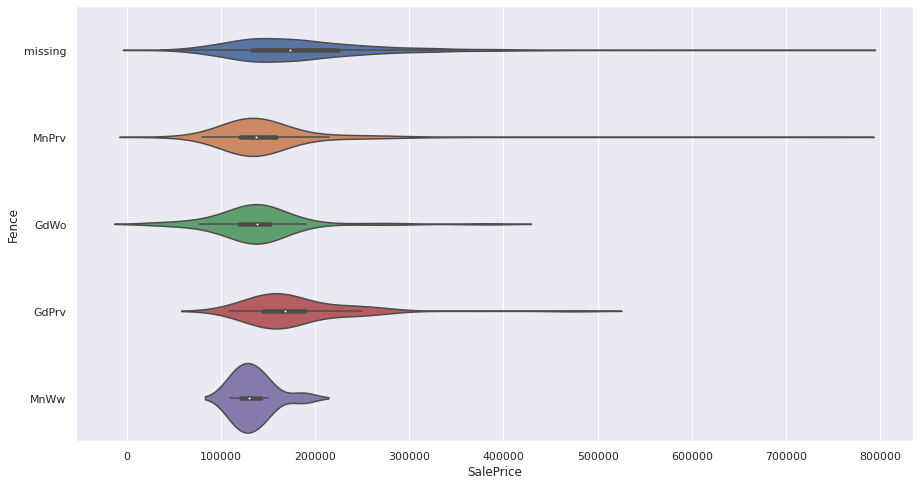

In [33]:
plt.figure(figsize=(15,8))
ax = sns.violinplot(x="SalePrice", y="Fence", 
                 data=exp_data,
                 orient="h", fliersize=2)

In [80]:
import scipy

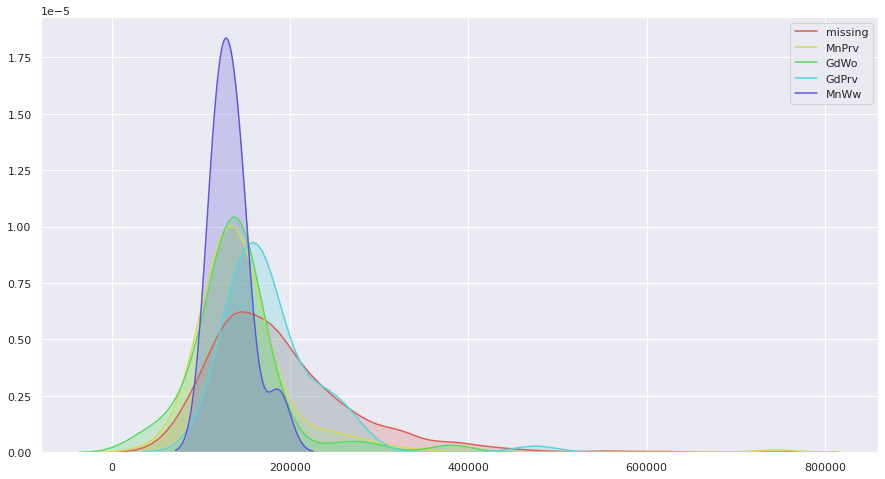

In [83]:
plt.figure(figsize=(15,8))
i = 0
for classe in exp_data["Fence"].unique():
    d = pd.DataFrame(exp_data.loc[exp_data['Fence'] == classe, "SalePrice"])
    d.rename(columns={'SalePrice': classe}, inplace=True)
    p1=sns.kdeplot(d[classe],
                   shade=True, 
                   color=sns.color_palette("hls", 12)[i])
    i=i+2